# Household Electric Power Consumption

Method used: LSTM with rolling lags, preprocessing and feature engineering.

### By Pratham Shah (B.Tech CSE, 240905614, 2028) for the Cryptonite Research Taskphase

## Imports and Loading the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping

df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, na_values=['nan','?'])
df = df.copy()

2025-07-03 04:00:17.965158: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 04:00:17.975106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751495417.985159   39447 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751495417.988101   39447 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751495417.996304   39447 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# EDA

In [2]:
print("DATA INFORMATION:")
print(df.info())
print("\n\nDATA DESCRIPTION")
print(df.describe())

DATA INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date_time              datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB
None


DATA DESCRIPTION
                           date_time  Global_active_power  \
count                        2075259         2.049280e+06   
mean   2008-12-06 07:12:59.999994112         1.091615e+00   
min              2006-12-16 17:24:00         7.600000e-02   
25%              2007-12-12 00:18:30         3.080000e-01   
50%              2008-12-06 07:13:00         6.020

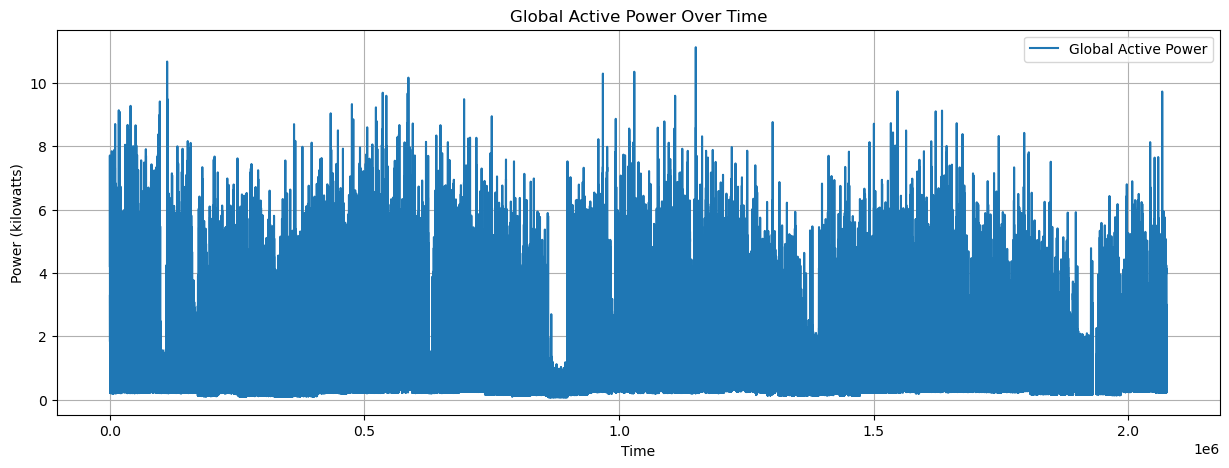

In [3]:
plt.figure(figsize=(15, 5))
plt.plot(df['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Over Time')
plt.ylabel('Power (kilowatts)')
plt.xlabel('Time')
plt.grid(True)
plt.legend()
plt.show()

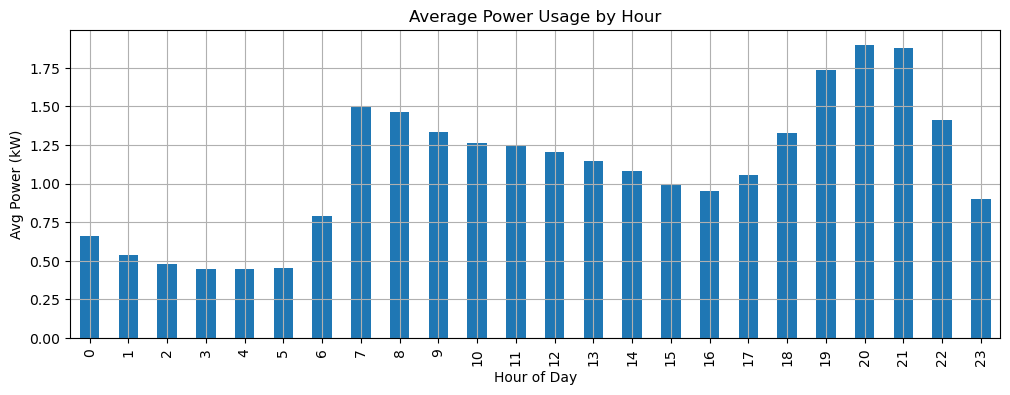

In [4]:
df_temp = df.copy()
hourly_avg = df_temp.groupby(df_temp["date_time"].dt.hour)['Global_active_power'].mean()

plt.figure(figsize=(12, 4))
hourly_avg.plot(kind='bar')
plt.title('Average Power Usage by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Avg Power (kW)')
plt.grid(True)
plt.show()


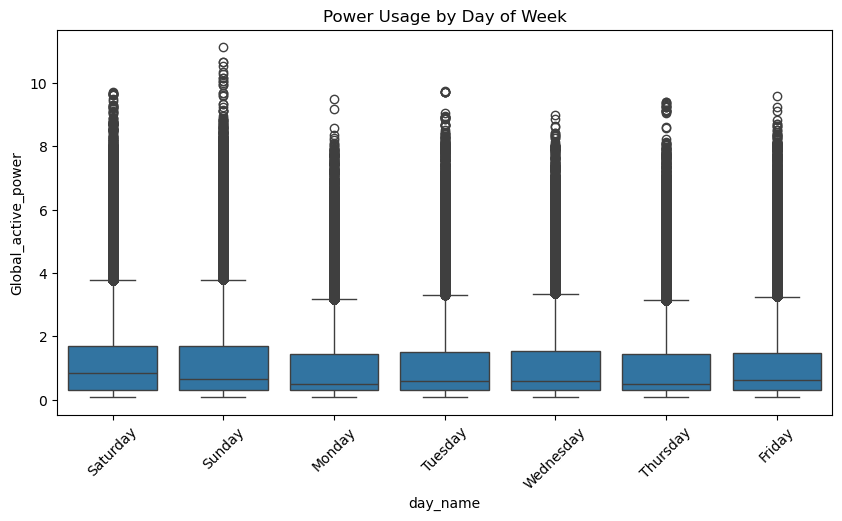

In [5]:
df_temp['day_name'] = df_temp["date_time"].dt.day_name()

plt.figure(figsize=(10, 5))
sns.boxplot(x='day_name', y='Global_active_power', data=df_temp)
plt.title('Power Usage by Day of Week')
plt.xticks(rotation=45)
plt.show()

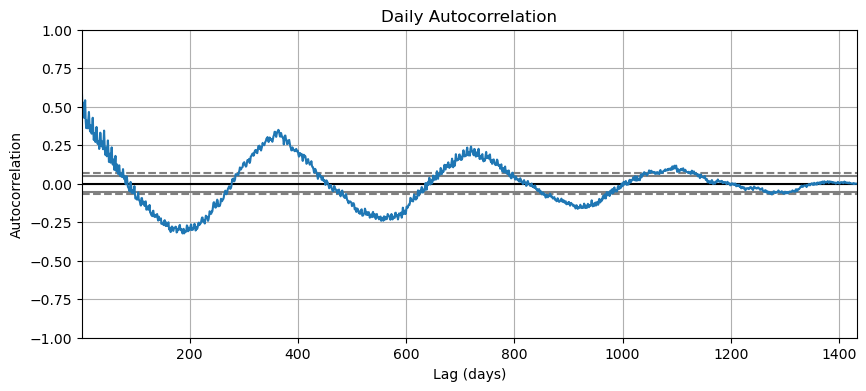

In [6]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

df_temp.set_index('date_time', inplace=True)
df_daily = df_temp['Global_active_power'].resample('D').mean()

plt.figure(figsize=(10, 4))
autocorrelation_plot(df_daily.dropna())
plt.title('Daily Autocorrelation')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


## Feature Engineering

Additon of new time features and lags (in mins) to give the models more agency to compute time based dependencies based on only historical data.

In [7]:
df['year'] = df['date_time'].dt.year
df['quarter'] = df['date_time'].dt.quarter
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour_of_day'] = df['date_time'].dt.hour #creating new columns to better capture time dependencies
df['is_weekend'] = df['date_time'].dt.dayofweek >= 5
df['is_weekend'] = df['is_weekend'].astype(int)  #weekend : 1, weekday : 0. idea is that weekend signifies greater consumption

for lag in [5, 30, 60, 60*24]: #rolling lag of 1min, 1hr, 1day
    df[f'lag_{lag}_minute'] = df['Global_active_power'].shift(lag)
    
df.sort_values('date_time', inplace=True, ascending=True) #sorts by asceding datemtime, matches index to these updated values
df = df.reset_index(drop=True)

df.dropna(inplace=True) #drop all null/nan values introduced by rolling lag and within the dataset

df

,date_time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,quarter,month,day,hour_of_day,is_weekend,lag_5_minute,lag_30_minute,lag_60_minute,lag_1440_minute
1440,2006-12-17 17:24:00,3.390,0.170,232.65,14.6,0.0,0.0,17.0,2006,4,12,17,17,1,3.808,3.328,4.864,4.216
1441,2006-12-17 17:25:00,3.360,0.164,231.20,14.4,0.0,0.0,16.0,2006,4,12,17,17,1,3.580,3.316,4.868,5.360
1442,2006-12-17 17:26:00,3.400,0.162,232.86,14.6,0.0,0.0,17.0,2006,4,12,17,17,1,3.370,3.390,4.876,5.374
1443,2006-12-17 17:27:00,3.396,0.164,232.89,14.6,0.0,0.0,17.0,2006,4,12,17,17,1,3.130,3.418,4.810,5.388
1444,2006-12-17 17:28:00,3.282,0.100,232.33,14.0,0.0,0.0,16.0,2006,4,12,17,17,1,3.238,3.384,4.790,3.666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,2010,4,11,26,20,0,0.944,0.982,1.526,1.522
2075255,2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,2010,4,11,26,20,0,0.946,0.958,1.524,1.518
2075256,2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,2010,4,11,26,21,0,0.946,0.980,1.456,1.512
2075257,2010-11-26 21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,2010,4,11,26,21,0,0.942,0.982,1.554,1.508


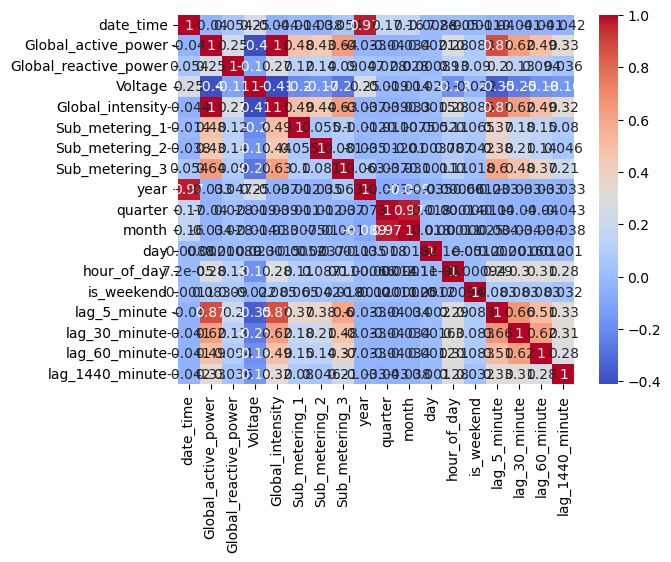

In [8]:
sns.heatmap(df.corr(), cmap="coolwarm", annot=True)
plt.show()

In [ ]:
df.drop(["date_time", "Global_intensity", "lag_5_minute"], axis=1, inplace=True)

print('Number of rows and columns:', df.shape)
print(list(df))

Number of rows and columns: (2037163, 16)
['date_time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'year', 'quarter', 'month', 'day', 'hour_of_day', 'is_weekend', 'lag_30_minute', 'lag_60_minute', 'lag_1440_minute']


I have removed intensity and lag 5 minute from the dataset because they have extremely high correlation to the output and thus lead the model to overfit and stop early. I want the model to pick up real predictions instead of simple patterns.

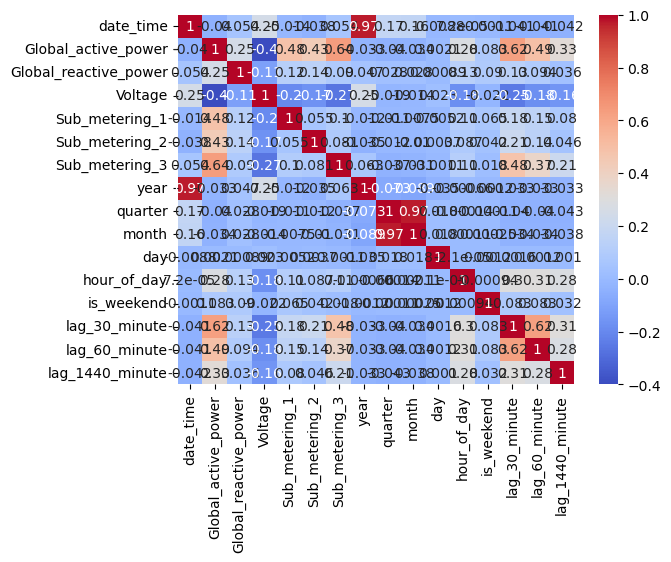

In [10]:
sns.heatmap(df.corr(), cmap="coolwarm", annot=True)
plt.show()

## Preparation for the Model

Z-score normalisation and scaling for the dataset to ensure standard importance to all features. reshaping the data to feed into the LSTM and creating windows for the LSTM to reference into history to allow it to build time-based predictions.

In [ ]:
dataset = df.values.astype('float32')
dataset = np.reshape(dataset, (-1, 1))  #reshaped for scaler and LSTM

size = int(len(dataset) * 0.80)
train, test = dataset[0:size], dataset[size:]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


In [12]:
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back]) 
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


In [13]:
look_back = 60
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## The Model

Complete with dropout to prevent overfitting and 2 sequential LSTM additons for more pattern recognition

In [14]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=1240, #the high batch size is needed because we are dealing with minute-to-minute data
    validation_data=(X_test, y_test), 
    callbacks=[EarlyStopping(monitor='val_loss', patience=4)], 
    verbose=1, 
    shuffle=False)

model.summary()


2025-07-03 04:00:30.176563: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/pratham/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.2097 - val_loss: 0.0403
Epoch 2/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0869 - val_loss: 0.0395
Epoch 3/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0842 - val_loss: 0.0394
Epoch 4/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0835 - val_loss: 0.0392
Epoch 5/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0819 - val_loss: 0.0390
Epoch 6/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0818 - val_loss: 0.0390
Epoch 7/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0812 - val_loss: 0.0389
Epoch 8/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0805 - val_loss: 0.0389
Epoch 9/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0799 - val_loss: 0.0390
Epoch 10/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0799 - val_loss: 0.0388
Epoch 11/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0804 - val_loss: 0.0387
Epoch 12

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        96,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,725 (1.67 MB)

 Trainable params: 146,241 (571.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 292,484 (1.12 MB)

## Predictions Evaluation

In [15]:
train_predict = model.predict(X_train).reshape(-1, 1)
test_predict = model.predict(X_test).reshape(-1, 1)

train_predict_inv = scaler.inverse_transform(train_predict)
test_predict_inv = scaler.inverse_transform(test_predict)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

print('Train MAE:', mean_absolute_error(y_train_inv, train_predict_inv))
print('Train RMSE:', mean_squared_error(y_train_inv, train_predict_inv))
print('Train R2:', r2_score(y_train_inv, train_predict_inv))

print('Test MAE:', mean_absolute_error(y_test_inv, test_predict_inv))
print('Test RMSE:', mean_squared_error(y_test_inv, test_predict_inv))
print('Test R2:', r2_score(y_test_inv, test_predict_inv))


50928/50928 ━━━━━━━━━━━━━━━━━━━━ 33s 653us/step
12731/12731 ━━━━━━━━━━━━━━━━━━━━ 8s 647us/step
Train MAE: 0.09752564877271652
Train RMSE: 0.06737842410802841
Train R2: 0.9435520768165588
Test MAE: 0.08265940099954605
Test RMSE: 0.04587483033537865
Test R2: 0.9431915283203125


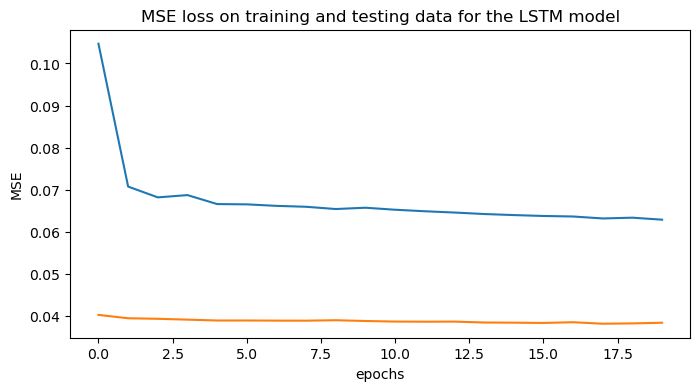

In [16]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title('MSE loss on training and testing data for the LSTM model')
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.show()

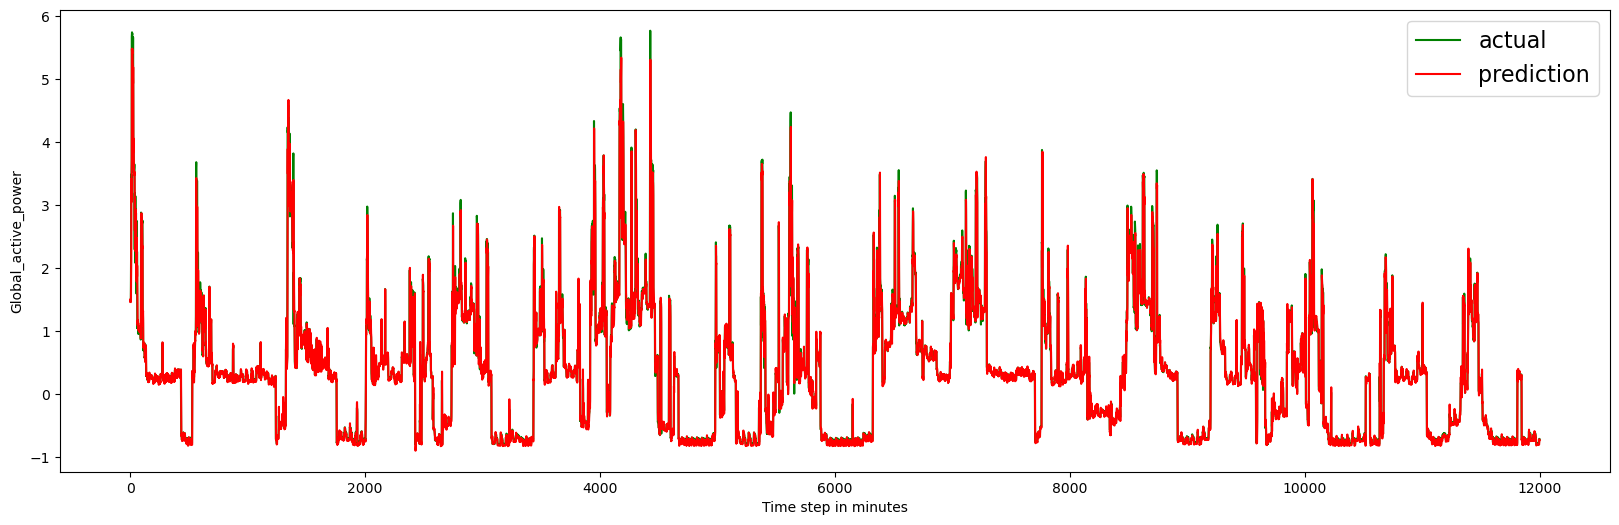

In [17]:
indice = 12000 #number of testing examples to use

limit = [x for x in range(indice)]
plt.figure(figsize=(20,6))

plt.plot(limit, y_test[:indice], label="actual", color='green')
plt.plot(limit, test_predict[:,0][:indice], '-', label="prediction", color='red')

plt.ylabel('Global_active_power')
plt.xlabel('Time step in minutes')
plt.legend(fontsize=16)

plt.show()


## Conclusion:

The model is predicting the electric power usage in a time-series bound way and is returning efficient results.